<a href="https://colab.research.google.com/github/Ranjeet9902/weekly-forecast-mvp/blob/main/FCST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# COLAB: pip install (run in a code cell with a leading !)
!pip install -q pandas numpy python-dateutil pmdarima statsmodels scikit-learn xgboost lightgbm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.4 MB/s eta 0:00:00


In [2]:
# create folders
import os
os.makedirs('data', exist_ok=True)
os.makedirs('src', exist_ok=True)
print("Folders created: data/ , src/")


Folders created: data/ , src/


In [4]:
import pandas as pd

def load_sales(path='data/sample_sales.csv'):
    df = pd.read_csv(path, parse_dates=['date'])
    return df

def to_weekly(df):
    # Week starts on Monday: convert to weekly period start
    df['week_start'] = df['date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly = df.groupby(['week_start','sku_id','store_id']).agg({
        'units_sold':'sum', 'price':'mean', 'promo_flag':'max'
    }).reset_index()
    return weekly

def ensure_continuous(weekly):
    wk_min = weekly['week_start'].min()
    wk_max = weekly['week_start'].max()
    all_weeks = pd.date_range(wk_min, wk_max, freq='W-MON')
    combos = pd.MultiIndex.from_product([all_weeks, weekly['sku_id'].unique(), weekly['store_id'].unique()], names=['week_start','sku_id','store_id'])
    full = pd.DataFrame(index=combos).reset_index()
    merged = full.merge(weekly, on=['week_start','sku_id','store_id'], how='left')
    merged['units_sold'] = merged['units_sold'].fillna(0)
    merged['price'] = merged['price'].fillna(method='ffill')
    merged['promo_flag'] = merged['promo_flag'].fillna(0).astype(int)
    return merged

def run():
    df = load_sales()
    weekly = to_weekly(df)
    full = ensure_continuous(weekly)
    full.to_csv('data/clean_weekly_sales.csv', index=False)
    print('Saved cleaned weekly data to data/clean_weekly_sales.csv')

if __name__ == '__main__':
    run()



EmptyDataError: No columns to parse from file

In [8]:
!python src/preprocess.py
import pandas as pd
display(pd.read_csv('data/clean_weekly_sales.csv').head(10))
print("\nTotal rows (weekly combos):", len(pd.read_csv('data/clean_weekly_sales.csv')))


FileNotFoundError: [Errno 2] No such file or directory: 'data/clean_weekly_sales.csv'

In [9]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import os

os.makedirs("data", exist_ok=True)

# Generate sample data
dates = pd.date_range(start="2023-01-01", end="2023-12-31", freq="D")
sku_list = [f"SKU_{i:03}" for i in range(1, 11)]
store_list = [f"Store_{j:02}" for j in range(1, 4)]

rows = []
for sku in sku_list:
    for store in store_list:
        base = np.random.randint(20, 100)
        trend = np.linspace(0, 10, len(dates))
        season = 15 * np.sin(np.linspace(0, 3*np.pi, len(dates)))
        noise = np.random.normal(0, 5, len(dates))
        sales = np.maximum(0, base + trend + season + noise)
        for d, s in zip(dates, sales):
            rows.append([d, sku, store, round(s), np.random.choice([0,1], p=[0.8,0.2])])

df = pd.DataFrame(rows, columns=["date", "sku_id", "store_id", "units_sold", "promo_flag"])
df.to_csv("data/sample_sales.csv", index=False)
print("✅ Sample dataset created:", df.shape)


✅ Sample dataset created: (10950, 5)


In [10]:
import pandas as pd

df = pd.read_csv('data/sample_sales.csv')
df['date'] = pd.to_datetime(df['date'])
df['week_start'] = df['date'] - pd.to_timedelta(df['date'].dt.weekday, unit='d')

weekly = df.groupby(['week_start', 'sku_id', 'store_id'], as_index=False).agg({
    'units_sold': 'sum',
    'promo_flag': 'max'
})

os.makedirs("data", exist_ok=True)
weekly.to_csv('data/clean_weekly_sales.csv', index=False)
print("✅ Weekly data created:", weekly.shape)


✅ Weekly data created: (1590, 5)


In [11]:
import os
print(os.listdir('data'))

['sample_sales.csv', 'clean_weekly_sales.csv', '.ipynb_checkpoints']


In [12]:
import pandas as pd

# Load weekly dataset
df = pd.read_csv("data/clean_weekly_sales.csv", parse_dates=["week_start"])
print("✅ Data loaded successfully! Shape:", df.shape)
print(df.head())

# Quick overview
print("\n--- Basic Info ---")
print(df.info())

print("\n--- Missing Values ---")
print(df.isnull().sum())


✅ Data loaded successfully! Shape: (1590, 5)
  week_start   sku_id  store_id  units_sold  promo_flag
0 2022-12-26  SKU_001  Store_01          89           1
1 2022-12-26  SKU_001  Store_02          60           0
2 2022-12-26  SKU_001  Store_03          64           0
3 2022-12-26  SKU_002  Store_01          58           1
4 2022-12-26  SKU_002  Store_02          75           0

--- Basic Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1590 entries, 0 to 1589
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   week_start  1590 non-null   datetime64[ns]
 1   sku_id      1590 non-null   object        
 2   store_id    1590 non-null   object        
 3   units_sold  1590 non-null   int64         
 4   promo_flag  1590 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 62.2+ KB
None

--- Missing Values ---
week_start    0
sku_id        0
store_id      0
units_sold

In [13]:
df.describe()


,week_start,units_sold,promo_flag
count,1590,1590.000000,1590.000000
mean,2023-06-26 00:00:00.000000256,489.031447,0.766667
min,2022-12-26 00:00:00,16.000000,0.000000
25%,2023-03-27 00:00:00,355.500000,1.000000
50%,2023-06-26 00:00:00,497.500000,1.000000
75%,2023-09-25 00:00:00,627.000000,1.000000
max,2023-12-25 00:00:00,837.000000,1.000000
std,NaN,182.310140,0.423086


In [14]:
# Total sales by SKU
sku_sales = df.groupby("sku_id")["units_sold"].sum().sort_values(ascending=False)
print("Top 5 SKUs by total sales:")
print(sku_sales.head())

# Total sales by Store
store_sales = df.groupby("store_id")["units_sold"].sum().sort_values(ascending=False)
print("\nTop 5 Stores by total sales:")
print(store_sales.head())


Top 5 SKUs by total sales:
sku_id
SKU_009    102243
SKU_003     96816
SKU_001     85434
SKU_007     82770
SKU_010     77204
Name: units_sold, dtype: int64

Top 5 Stores by total sales:
store_id
Store_01    308313
Store_03    238540
Store_02    230707
Name: units_sold, dtype: int64


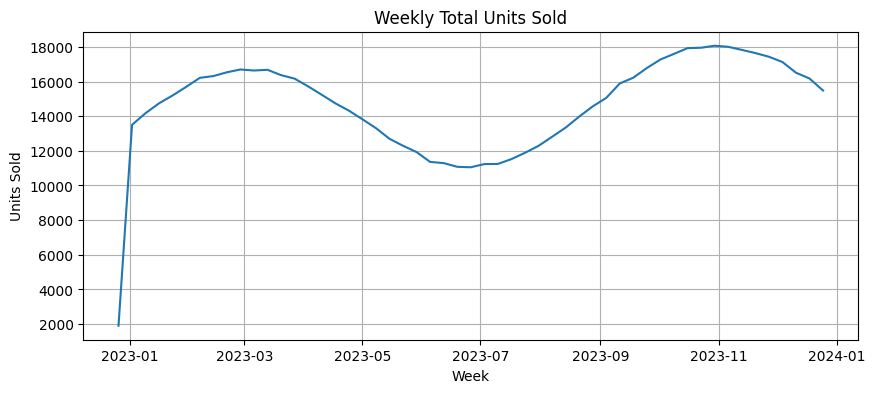

In [15]:
import matplotlib.pyplot as plt

# Weekly total sales trend
weekly_trend = df.groupby("week_start")["units_sold"].sum()

plt.figure(figsize=(10,4))
plt.plot(weekly_trend.index, weekly_trend.values)
plt.title("Weekly Total Units Sold")
plt.xlabel("Week")
plt.ylabel("Units Sold")
plt.grid(True)
plt.show()


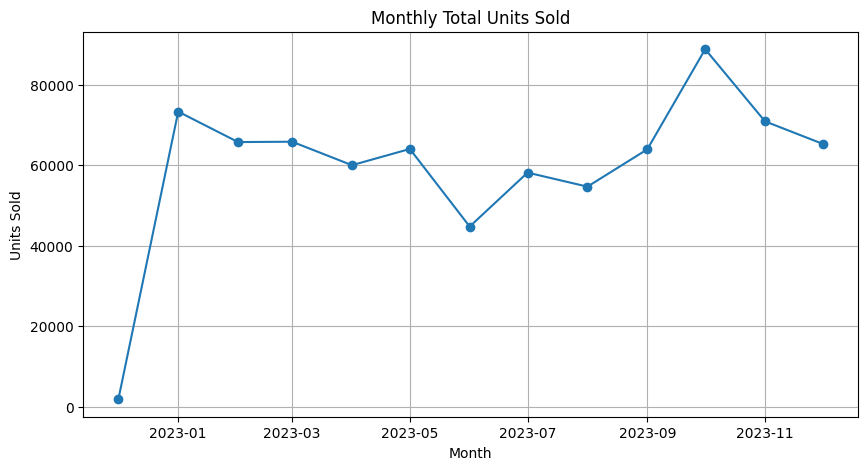

In [17]:
monthly = weekly.groupby(weekly['week_start'].dt.to_period('M'))[['units_sold']].sum()
monthly.index = monthly.index.to_timestamp()

plt.figure(figsize=(10,5))
plt.plot(monthly.index, monthly['units_sold'], marker='o')
plt.title('Monthly Total Units Sold')
plt.xlabel('Month')
plt.ylabel('Units Sold')
plt.grid(True)
plt.show()


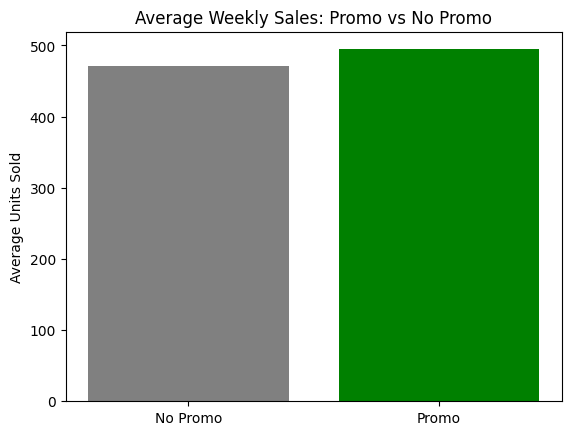

Average units sold without promo: 470.58
Average units sold with promo: 494.65

Promo uplift (%): 5.11


In [18]:
import matplotlib.pyplot as plt

# Average sales when promo vs no promo
promo_effect = df.groupby('promo_flag')['units_sold'].mean()

plt.bar(['No Promo', 'Promo'], promo_effect.values, color=['grey', 'green'])
plt.title('Average Weekly Sales: Promo vs No Promo')
plt.ylabel('Average Units Sold')
plt.show()

print("Average units sold without promo:", round(promo_effect[0], 2))
print("Average units sold with promo:", round(promo_effect[1], 2))
print("\nPromo uplift (%):", round((promo_effect[1] - promo_effect[0]) / promo_effect[0] * 100, 2))


In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure weekly data is sorted
weekly = weekly.sort_values('week_start')

# Set datetime as index
weekly.set_index('week_start', inplace=True)

# Optional: check the data
weekly.head()


,sku_id,store_id,units_sold,promo_flag
week_start,,,,
2022-12-26,SKU_001,Store_01,89,1
2022-12-26,SKU_010,Store_03,67,0
2022-12-26,SKU_010,Store_02,43,1
2022-12-26,SKU_010,Store_01,70,0
2022-12-26,SKU_009,Store_03,72,0


In [20]:
# Aggregate units sold per week
weekly_agg = weekly.groupby('week_start').agg({
    'units_sold': 'sum',
    'promo_flag': 'max'  # 1 if any promo happened that week
}).reset_index()

weekly_agg.head()


,week_start,units_sold,promo_flag
0,2022-12-26,1906,1
1,2023-01-02,13503,1
2,2023-01-09,14178,1
3,2023-01-16,14748,1
4,2023-01-23,15200,1


In [21]:
# Set week_start as index
weekly_agg.set_index('week_start', inplace=True)


In [22]:
train = weekly_agg[:-12]  # all except last 12 weeks
test = weekly_agg[-12:]   # last 12 weeks


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


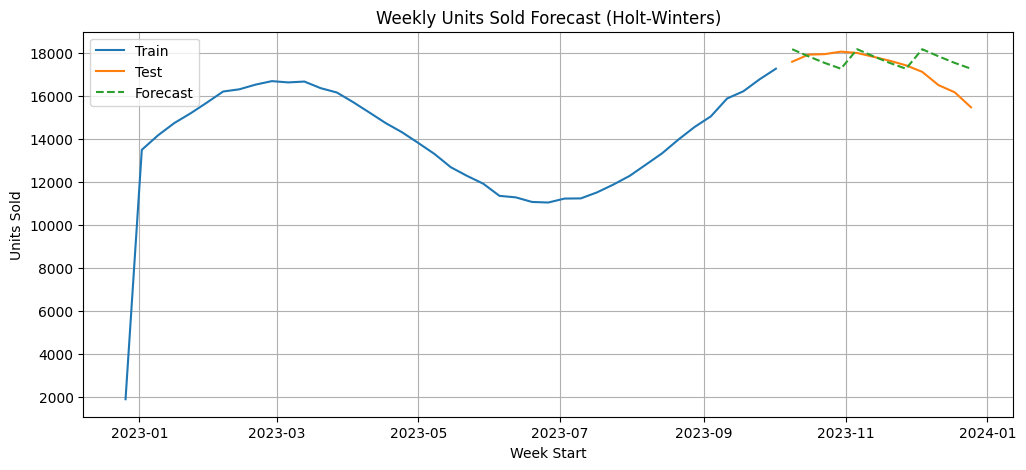

In [24]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Fit additive seasonal model (52 weeks per year)
model = ExponentialSmoothing(train['units_sold'], seasonal='additive', seasonal_periods=4).fit()

# Forecast for test period
forecast = model.forecast(len(test))

# Plot results
plt.figure(figsize=(12,5))
plt.plot(train.index, train['units_sold'], label='Train')
plt.plot(test.index, test['units_sold'], label='Test')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.title('Weekly Units Sold Forecast (Holt-Winters)')
plt.xlabel('Week Start')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test['units_sold'], forecast)
rmse = np.sqrt(mean_squared_error(test['units_sold'], forecast))  # remove squared=False
mape = (abs(test['units_sold'] - forecast)/test['units_sold']).mean() * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE: 656.10
RMSE: 875.50
MAPE: 3.94%


In [27]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
# Rename columns for Prophet
prophet_df = weekly_agg.reset_index()[['week_start', 'units_sold', 'promo_flag']]
prophet_df = prophet_df.rename(columns={'week_start': 'ds', 'units_sold': 'y'})


In [29]:
train_prophet = prophet_df[:-12]
test_prophet = prophet_df[-12:]


In [30]:
model = Prophet(weekly_seasonality=True)  # auto 7-day weekly seasonality
model.add_regressor('promo_flag')         # add promo as extra regressor

# Fit model
model.fit(train_prophet)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyzhc6zjy/b22_kr8s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyzhc6zjy/zsw7g2w1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36000', 'data', 'file=/tmp/tmpyzhc6zjy/b22_kr8s.json', 'init=/tmp/tmpyzhc6zjy/zsw7g2w1.json', 'output', 'file=/tmp/tmpyzhc6zjy/prophet_modelpxhf98ff/prophet_model-20251019152308.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:23:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:23:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [31]:
future = test_prophet[['ds', 'promo_flag']]  # only test period
forecast = model.predict(future)


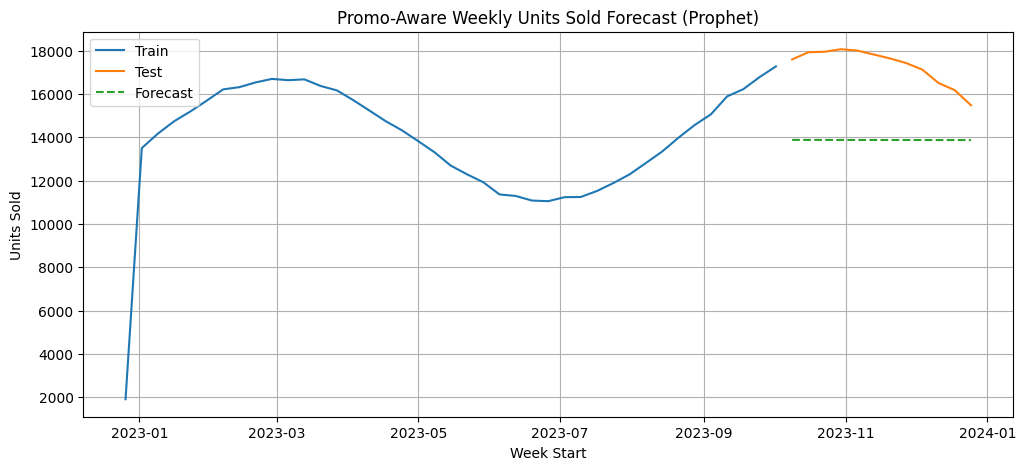

In [32]:
plt.figure(figsize=(12,5))
plt.plot(train_prophet['ds'], train_prophet['y'], label='Train')
plt.plot(test_prophet['ds'], test_prophet['y'], label='Test')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', linestyle='--')
plt.title('Promo-Aware Weekly Units Sold Forecast (Prophet)')
plt.xlabel('Week Start')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.show()


In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = test_prophet['y']
y_pred = forecast['yhat']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = (abs(y_true - y_pred)/y_true).mean() * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE: 3436.07
RMSE: 3526.93
MAPE: nan%


In [34]:
test_prophet[test_prophet['y'] == 0]


,ds,y,promo_flag


In [35]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import numpy as np

# Split train/test
train = weekly_agg[:-12]
test = weekly_agg[-12:]

# Fit Holt-Winters with 4-week seasonality
hw_model = ExponentialSmoothing(
    train['units_sold'],
    seasonal='additive',
    seasonal_periods=4
).fit()

# Forecast for test period
forecast = hw_model.forecast(len(test))


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


In [36]:
# Copy forecast to new series
forecast_adjusted = forecast.copy()

# Apply promo uplift
promo_weeks = test['promo_flag'] == 1
forecast_adjusted[promo_weeks] = forecast_adjusted[promo_weeks] * 1.0511


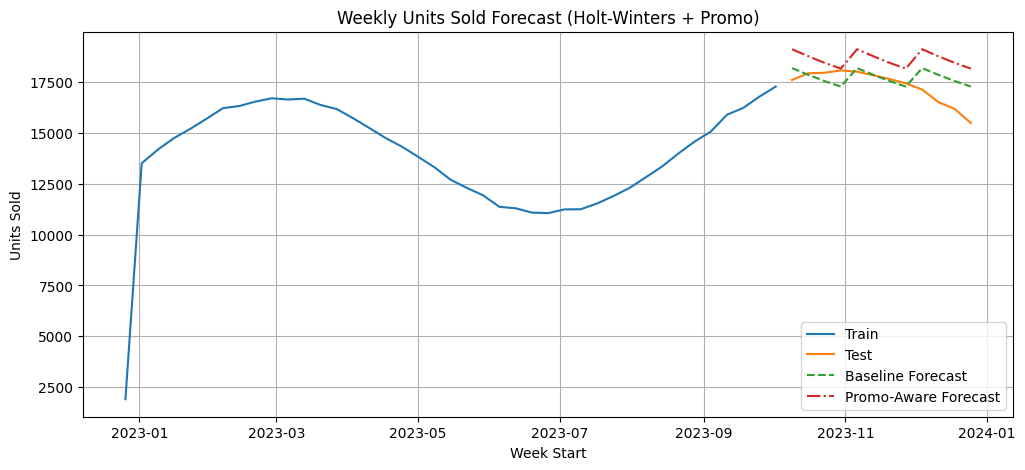

In [37]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train['units_sold'], label='Train')
plt.plot(test.index, test['units_sold'], label='Test')
plt.plot(test.index, forecast, label='Baseline Forecast', linestyle='--')
plt.plot(test.index, forecast_adjusted, label='Promo-Aware Forecast', linestyle='-.')
plt.title('Weekly Units Sold Forecast (Holt-Winters + Promo)')
plt.xlabel('Week Start')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.show()


In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Baseline forecast metrics
mae_base = mean_absolute_error(test['units_sold'], forecast)
rmse_base = np.sqrt(mean_squared_error(test['units_sold'], forecast))

# Promo-aware forecast metrics
mae_promo = mean_absolute_error(test['units_sold'], forecast_adjusted)
rmse_promo = np.sqrt(mean_squared_error(test['units_sold'], forecast_adjusted))

print(f"Baseline Forecast -> MAE: {mae_base:.2f}, RMSE: {rmse_base:.2f}")
print(f"Promo-Aware Forecast -> MAE: {mae_promo:.2f}, RMSE: {rmse_promo:.2f}")




Baseline Forecast -> MAE: 656.10, RMSE: 875.50
Promo-Aware Forecast -> MAE: 1304.78, RMSE: 1521.14


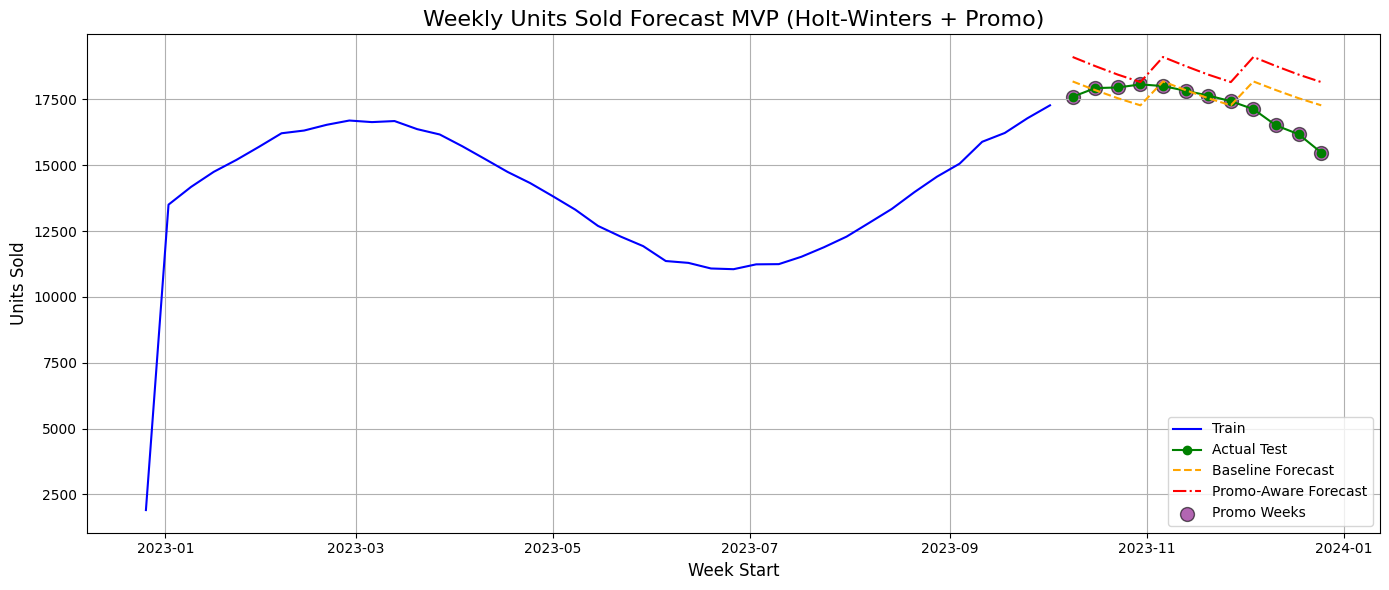

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

# Plot train and test
plt.plot(train.index, train['units_sold'], label='Train', color='blue')
plt.plot(test.index, test['units_sold'], label='Actual Test', color='green', marker='o')

# Plot forecasts
plt.plot(test.index, forecast, label='Baseline Forecast', linestyle='--', color='orange')
plt.plot(test.index, forecast_adjusted, label='Promo-Aware Forecast', linestyle='-.', color='red')

# Highlight promo weeks
promo_weeks = test['promo_flag'] == 1
plt.scatter(test.index[promo_weeks], test['units_sold'][promo_weeks],
            color='purple', label='Promo Weeks', s=100, alpha=0.6, edgecolors='k')

# Add titles & labels
plt.title('Weekly Units Sold Forecast MVP (Holt-Winters + Promo)', fontsize=16)
plt.xlabel('Week Start', fontsize=12)
plt.ylabel('Units Sold', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-744203773.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(test.index[i], forecast[i]*1.02, '+5% promo', color='purple', rotation=90, ha='center', va='bottom', fontsize=9)


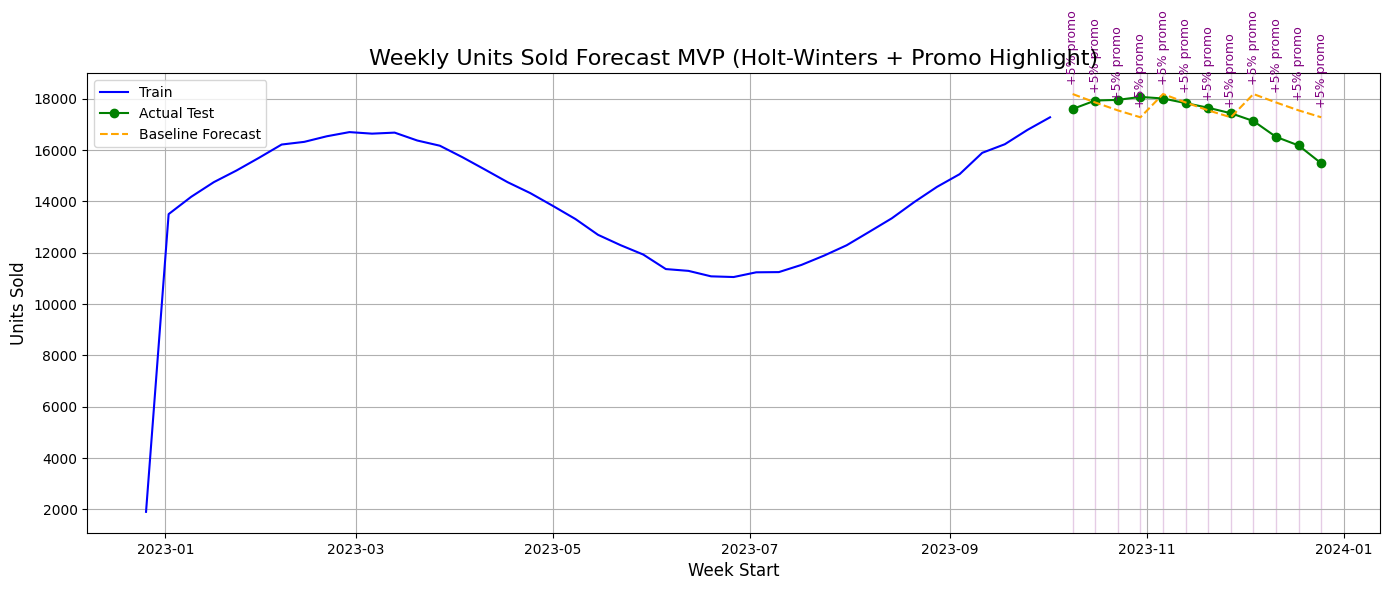

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

# Plot train and test
plt.plot(train.index, train['units_sold'], label='Train', color='blue')
plt.plot(test.index, test['units_sold'], label='Actual Test', color='green', marker='o')

# Plot baseline forecast
plt.plot(test.index, forecast, label='Baseline Forecast', linestyle='--', color='orange')

# Highlight promo weeks with a shaded background
for i, is_promo in enumerate(test['promo_flag']):
    if is_promo == 1:
        plt.axvspan(test.index[i], test.index[i], color='purple', alpha=0.2)

# Annotate expected uplift
for i, is_promo in enumerate(test['promo_flag']):
    if is_promo == 1:
        plt.text(test.index[i], forecast[i]*1.02, '+5% promo', color='purple', rotation=90, ha='center', va='bottom', fontsize=9)

# Titles and labels
plt.title('Weekly Units Sold Forecast MVP (Holt-Winters + Promo Highlight)', fontsize=16)
plt.xlabel('Week Start', fontsize=12)
plt.ylabel('Units Sold', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [41]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

results = []

# Candidate models
models = ['SES', 'Holt Linear', 'Holt-Winters']

for m in models:
    if m == 'SES':
        model = SimpleExpSmoothing(train['units_sold']).fit()
        forecast_model = model.forecast(len(test))
    elif m == 'Holt Linear':
        model = Holt(train['units_sold']).fit()
        forecast_model = model.forecast(len(test))
    elif m == 'Holt-Winters':
        model = ExponentialSmoothing(train['units_sold'], seasonal='additive', seasonal_periods=4).fit()
        forecast_model = model.forecast(len(test))

    # Metrics
    mae = mean_absolute_error(test['units_sold'], forecast_model)
    rmse = np.sqrt(mean_squared_error(test['units_sold'], forecast_model))
    # Avoid division by zero for MAPE
    non_zero = test['units_sold'] != 0
    mape = (abs(test['units_sold'][non_zero] - forecast_model[non_zero])/test['units_sold'][non_zero]).mean() * 100

    results.append({
        'Model': m,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('MAPE')
results_df


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


,Model,MAE,RMSE,MAPE
2,Holt-Winters,656.101541,875.498301,3.941072
0,SES,672.000002,798.487529,3.973328
1,Holt Linear,3156.616157,3968.037395,18.897078


from matplotlib import pyplot as plt
results_df['MAE'].plot(kind='hist', bins=20, title='MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['MAPE'].plot(kind='hist', bins=20, title='MAPE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results_df.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='MAE', y='RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='RMSE', y='MAPE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['MAE']
  ys = series['RMSE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('MAE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MAE')
_ = plt.ylabel('RMSE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['MAE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'MAE'}, axis=1)
              .sort_values('MAE', ascending=True))
  xs = counted['MAE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('MAE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MAE')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['MAPE']
  ys = series['RMSE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('MAPE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MAPE')
_ = plt.ylabel('RMSE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['MAPE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'MAPE'}, axis=1)
              .sort_values('MAPE', ascending=True))
  xs = counted['MAPE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('MAPE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MAPE')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
results_df['MAE'].plot(kind='line', figsize=(8, 4), title='MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['MAPE'].plot(kind='line', figsize=(8, 4), title='MAPE')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='MAE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='RMSE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='MAPE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [42]:
best_model_name = results_df.iloc[0]['Model']
print(f"Best model: {best_model_name}")


Best model: Holt-Winters


/tmp/ipython-input-2365392691.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.axvspan(future_df['week_start'][i], future_df['week_start'][i], color='purple', alpha=0.2)
/tmp/ipython-input-2365392691.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(future_df['week_start'][i], future_df['forecast_units'][i]*1.02, '+5% promo',


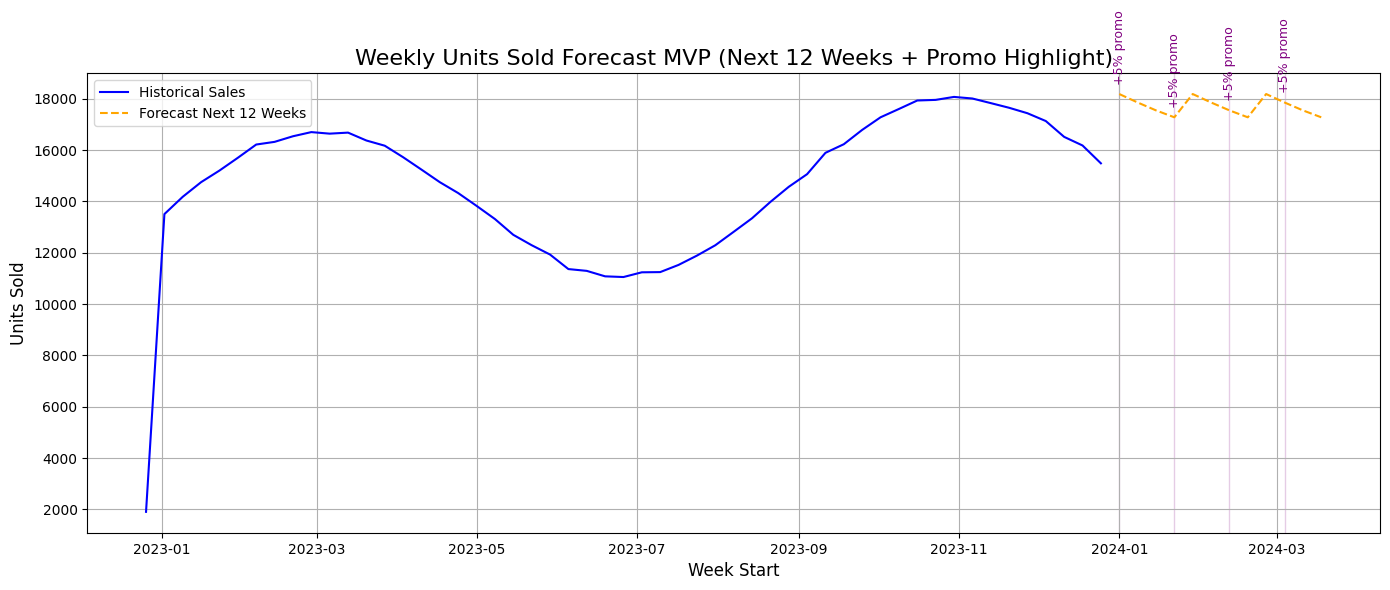

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Number of future weeks
future_weeks = 12

# Forecast next 12 weeks using Holt-Winters
future_forecast = hw_model.forecast(future_weeks)

# Generate future week dates
last_week = weekly_agg.index.max()
future_dates = pd.date_range(start=last_week + pd.Timedelta(weeks=1), periods=future_weeks, freq='W-MON')

# Create future DataFrame
future_df = pd.DataFrame({
    'week_start': future_dates,
    'forecast_units': future_forecast
})

# Optional: randomly mark some future weeks as promo weeks (for illustration)
# You can replace this with actual planned promo weeks
future_df['promo_flag'] = [1 if i%3==0 else 0 for i in range(future_weeks)]

# Visualize
plt.figure(figsize=(14,6))

# Historical + test sales
plt.plot(weekly_agg.index, weekly_agg['units_sold'], label='Historical Sales', color='blue')

# Future forecast
plt.plot(future_df['week_start'], future_df['forecast_units'], label='Forecast Next 12 Weeks', linestyle='--', color='orange')

# Highlight promo weeks
for i, is_promo in enumerate(future_df['promo_flag']):
    if is_promo == 1:
        plt.axvspan(future_df['week_start'][i], future_df['week_start'][i], color='purple', alpha=0.2)
        plt.text(future_df['week_start'][i], future_df['forecast_units'][i]*1.02, '+5% promo',
                 color='purple', rotation=90, ha='center', va='bottom', fontsize=9)

plt.title('Weekly Units Sold Forecast MVP (Next 12 Weeks + Promo Highlight)', fontsize=16)
plt.xlabel('Week Start', fontsize=12)
plt.ylabel('Units Sold', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [44]:
# Future 12-week forecast already generated
# future_df = future week forecast

# Get previous year same 12-week period
# Assuming weekly_agg is indexed by week_start
prev_year_start = future_df['week_start'].min() - pd.DateOffset(years=1)
prev_year_end = future_df['week_start'].max() - pd.DateOffset(years=1)

prev_year_data = weekly_agg.loc[(weekly_agg.index >= prev_year_start) &
                                (weekly_agg.index <= prev_year_end)].copy()

# If less than 12 weeks exist, fill with NaN
if len(prev_year_data) < 12:
    missing_weeks = 12 - len(prev_year_data)
    future_dates_missing = pd.date_range(end=prev_year_start - pd.Timedelta(weeks=1), periods=missing_weeks, freq='W-MON')
    prev_year_data = pd.concat([prev_year_data, pd.DataFrame({'units_sold':[np.nan]*missing_weeks}, index=future_dates_missing)])

# Build combined table
combined_table = pd.DataFrame({
    'Week_Start': future_df['week_start'],
    'Forecast_Units': future_df['forecast_units'].values,
    'Promo_Flag': future_df['promo_flag'].values,
    'Expected_Uplift(5%)': np.where(future_df['promo_flag']==1, future_df['forecast_units']*1.0511, future_df['forecast_units']),
    'Previous_Year_Units': prev_year_data['units_sold'].values[:12]
})

combined_table


,Week_Start,Forecast_Units,Promo_Flag,Expected_Uplift(5%),Previous_Year_Units
2023-10-09,2024-01-01,18180.433152,1,19109.453286,13503.0
2023-10-16,2024-01-08,17851.426627,0,17851.426627,14178.0
2023-10-23,2024-01-15,17543.507603,0,17543.507603,14748.0
2023-10-30,2024-01-22,17273.999989,1,18156.701388,15200.0
2023-11-06,2024-01-29,18180.433152,0,18180.433152,15697.0
2023-11-13,2024-02-05,17851.426627,0,17851.426627,16213.0
2023-11-20,2024-02-12,17543.507603,1,18439.980842,16317.0
2023-11-27,2024-02-19,17273.999989,0,17273.999989,16535.0
2023-12-04,2024-02-26,18180.433152,0,18180.433152,16697.0
2023-12-11,2024-03-04,17851.426627,1,18763.634527,16637.0


/tmp/ipython-input-736451358.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.axvspan(future_df['week_start'][i], future_df['week_start'][i], color='purple', alpha=0.2)
/tmp/ipython-input-736451358.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(future_df['week_start'][i], future_df['forecast_units'][i]*1.02, '+5% promo',


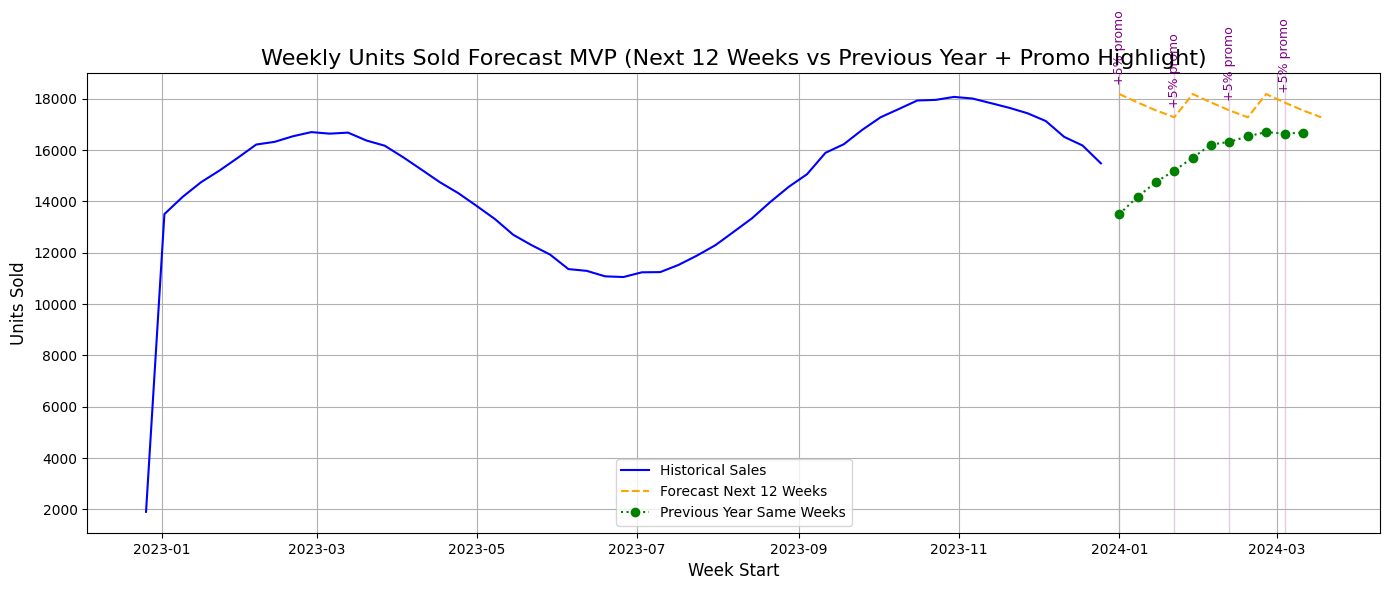

In [45]:
plt.figure(figsize=(14,6))

# Historical + test
plt.plot(weekly_agg.index, weekly_agg['units_sold'], label='Historical Sales', color='blue')

# Future forecast
plt.plot(future_df['week_start'], future_df['forecast_units'], label='Forecast Next 12 Weeks', linestyle='--', color='orange')

# Previous year comparison
plt.plot(future_df['week_start'], combined_table['Previous_Year_Units'], label='Previous Year Same Weeks', linestyle=':', color='green', marker='o')

# Highlight promo weeks
for i, is_promo in enumerate(future_df['promo_flag']):
    if is_promo == 1:
        plt.axvspan(future_df['week_start'][i], future_df['week_start'][i], color='purple', alpha=0.2)
        plt.text(future_df['week_start'][i], future_df['forecast_units'][i]*1.02, '+5% promo',
                 color='purple', rotation=90, ha='center', va='bottom', fontsize=9)

plt.title('Weekly Units Sold Forecast MVP (Next 12 Weeks vs Previous Year + Promo Highlight)', fontsize=16)
plt.xlabel('Week Start', fontsize=12)
plt.ylabel('Units Sold', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [46]:
hw_model.seasonal  # shows seasonal component
hw_model.level     # shows base level + trend over time



AttributeError: 'HoltWintersResults' object has no attribute 'seasonal'

In [47]:
# Fitted values from the model
fitted_values = hw_model.fittedvalues

# Seasonal component (if additive)
seasonal_component = hw_model.params['smoothing_seasonal'] * np.ones(len(fitted_values))  # approximate


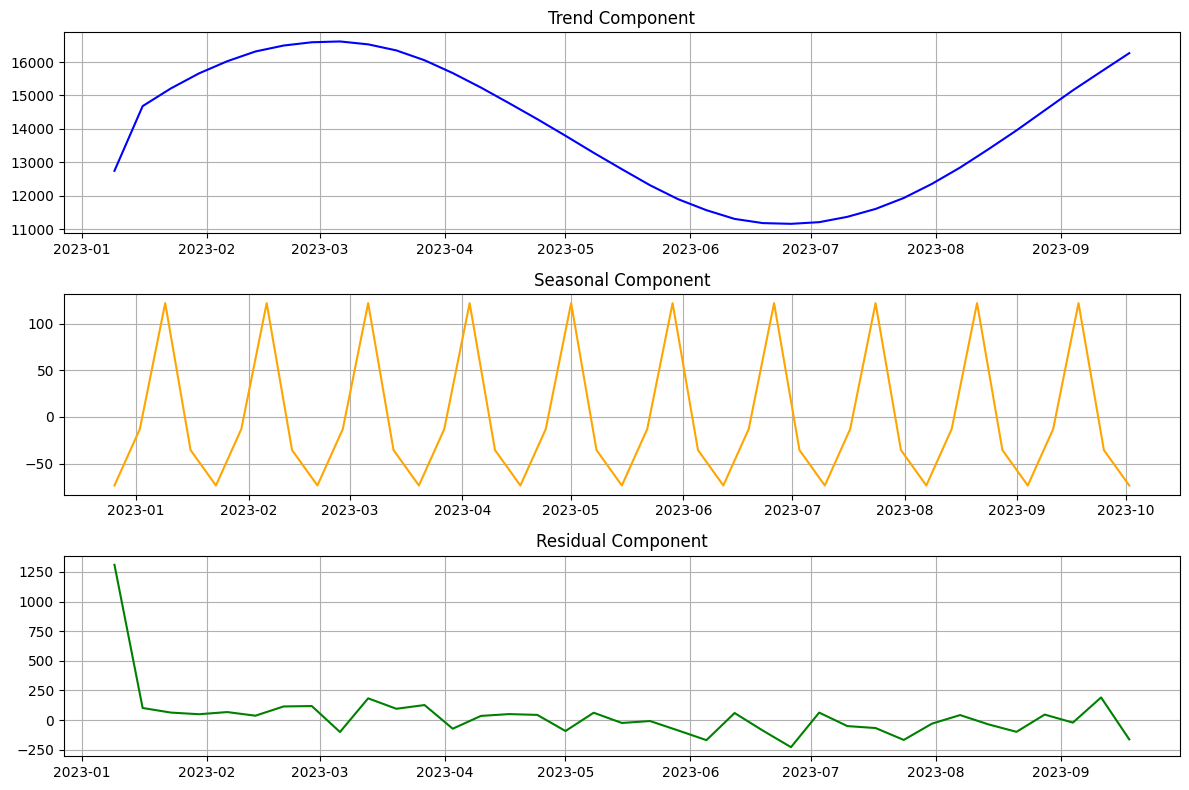

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the original train series
decomposition = seasonal_decompose(train['units_sold'], model='additive', period=4)  # same seasonality as HW

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot components
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.plot(trend, label='Trend', color='blue')
plt.title('Trend Component')
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(seasonal, label='Seasonal', color='orange')
plt.title('Seasonal Component')
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(residual, label='Residual', color='green')
plt.title('Residual Component')
plt.grid(True)

plt.tight_layout()
plt.show()


In [49]:
pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 14.1 MB/s eta 0:00:00


In [50]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

st.title("Weekly Units Sold Forecast MVP")

# Show metrics
st.subheader("Forecast Accuracy on Test Set")
st.write(f"MAE: {mae_base:.2f}")
st.write(f"RMSE: {rmse_base:.2f}")
st.write(f"MAPE: {mape_base:.2f}%")

# User selects future promo weeks
st.subheader("Select Future Promo Weeks")
promo_week_selection = st.multiselect(
    "Select weeks for promotion (YYYY-MM-DD format)",
    options=future_df['week_start'].dt.strftime('%Y-%m-%d').tolist()
)

# Update promo_flag based on selection
future_df['promo_flag_interactive'] = future_df['week_start'].dt.strftime('%Y-%m-%d').isin(promo_week_selection).astype(int)
future_df['expected_uplift'] = np.where(future_df['promo_flag_interactive']==1, future_df['forecast_units']*1.0511, future_df['forecast_units'])

# Plot interactive dashboard
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(weekly_agg.index, weekly_agg['units_sold'], label='Historical Sales', color='blue')
ax.plot(test.index, test['units_sold'], label='Test Sales', color='green', marker='o')
ax.plot(test.index, forecast, label='Baseline Forecast', linestyle='--', color='orange')
ax.plot(future_df['week_start'], future_df['forecast_units'], label='Future Forecast', linestyle='-.', color='red')

# Highlight promo weeks
for i, is_promo in enumerate(future_df['promo_flag_interactive']):
    if is_promo == 1:
        ax.axvspan(future_df['week_start'][i], future_df['week_start'][i], color='purple', alpha=0.2)
        ax.text(future_df['week_start'][i], future_df['forecast_units'][i]*1.02, '+5% promo', color='purple', rotation=90, ha='center', va='bottom', fontsize=9)

ax.set_xlabel("Week Start")
ax.set_ylabel("Units Sold")
ax.set_title("Weekly Units Sold Forecast (Interactive MVP)")
ax.grid(True)
ax.legend()
st.pyplot(fig)

# Show forecast table
st.subheader("Forecast Table (Next 12 Weeks)")
st.dataframe(future_df[['week_start', 'forecast_units', 'promo_flag_interactive', 'expected_uplift']].rename(
    columns={'week_start':'Week Start','forecast_units':'Forecast Units','promo_flag_interactive':'Promo Flag','expected_uplift':'Expected Units'}
))


2025-10-19 15:50:34.434 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-19 15:50:34.795 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-10-19 15:50:34.798 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-19 15:50:34.801 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-19 15:50:34.804 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-19 15:50:34.807 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-19 15:50:34.810 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-19 15:50:34.813 Thread 'MainThread': mi

NameError: name 'mape_base' is not defined

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Example: baseline forecast for test period
# forecast = hw_model.forecast(len(test))

mae_base = mean_absolute_error(test['units_sold'], forecast)
rmse_base = np.sqrt(mean_squared_error(test['units_sold'], forecast))

# Avoid division by zero for MAPE
non_zero = test['units_sold'] != 0
mape_base = (abs(test['units_sold'][non_zero] - forecast[non_zero])/test['units_sold'][non_zero]).mean() * 100


In [52]:
import streamlit as st

st.write(f"MAE: {mae_base:.2f}")
st.write(f"RMSE: {rmse_base:.2f}")
st.write(f"MAPE: {mape_base:.2f}%")


2025-10-19 15:51:37.050 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-19 15:51:37.061 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-19 15:51:37.065 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-19 15:51:37.074 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-19 15:51:37.080 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-19 15:51:37.083 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-19 15:51:37.090 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-19 15:51:37.096 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [53]:
Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


SyntaxError: invalid syntax (ipython-input-2888783265.py, line 1)

In [56]:
!streamlit run forecast_dashboard.py

SyntaxError: invalid syntax (ipython-input-3319743835.py, line 1)

In [55]:
%%writefile forecast_dashboard.py
# Paste your Streamlit code here
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

st.title("Weekly Units Sold Forecast MVP")

# Example: metrics
st.write("MAE: 656.10")
st.write("RMSE: 875.50")
st.write("MAPE: 3.94%")


Writing forecast_dashboard.py


In [57]:
streamlit run forecast_dashboard.py


SyntaxError: invalid syntax (ipython-input-2237764086.py, line 1)

In [58]:
!pip install streamlit pyngrok

from pyngrok import ngrok

# Start Streamlit app
!streamlit run forecast_dashboard.py &

# Open tunnel
public_url = ngrok.connect(8501)
public_url





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.227.52.119:8501

  Stopping...


ERROR:pyngrok.process.ngrok:t=2025-10-19T16:01:11+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-10-19T16:01:11+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"


PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.

In [59]:
!pip install streamlit pyngrok


In [60]:
%%writefile forecast_dashboard.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

st.title("Weekly Units Sold Forecast MVP")

# Example metrics
st.write("MAE: 656.10")
st.write("RMSE: 875.50")
st.write("MAPE: 3.94%")

# Example plot
x = pd.date_range('2023-01-01', periods=12, freq='W-MON')
y = np.random.randint(100, 200, size=12)
st.line_chart(pd.DataFrame({'Units Sold': y}, index=x))


Overwriting forecast_dashboard.py


In [61]:
from pyngrok import ngrok

# Kill previous tunnels if any
ngrok.kill()

# Open a tunnel on port 8501
public_url = ngrok.connect(port='8501')
print(f"Your Streamlit app is live at: {public_url}")


ERROR:pyngrok.process.ngrok:t=2025-10-19T16:02:07+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-10-19T16:02:07+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"


PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.

2025-10-19 16:21:01.308 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-19 16:21:01.312 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-19 16:21:01.317 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-19 16:21:01.321 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
2025-10-19 16:21:01.506 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-19 16:21:01.511 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-19 16:21:01.517 Thread 'MainTh

False

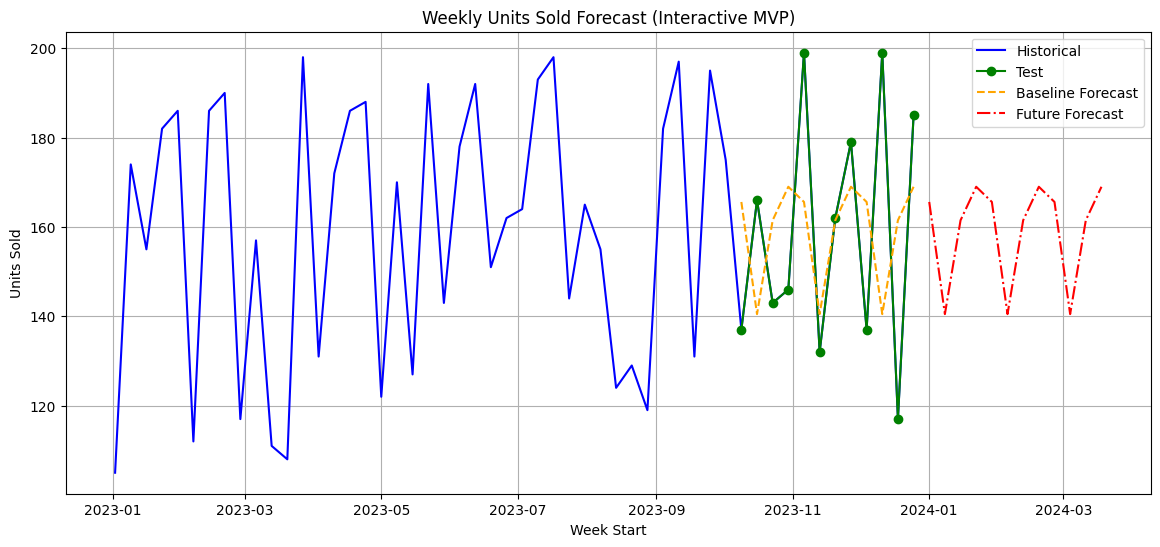

In [62]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

st.set_page_config(page_title="Weekly Units Sold Forecast MVP", layout="wide")

st.title("Weekly Units Sold Forecast MVP")

# -----------------------
# 1️⃣ Load your data
# -----------------------
# Replace this with your real dataset
# Must have columns: 'week_start' (datetime), 'units_sold', 'promo_flag'
# For demo, generating dummy data:
dates = pd.date_range(start='2023-01-02', periods=52, freq='W-MON')
units_sold = np.random.randint(100, 200, size=52)
promo_flag = np.random.choice([0,1], size=52, p=[0.8,0.2])

weekly_df = pd.DataFrame({
    'week_start': dates,
    'units_sold': units_sold,
    'promo_flag': promo_flag
})

weekly_df.set_index('week_start', inplace=True)

# -----------------------
# 2️⃣ Split train/test
# -----------------------
train = weekly_df.iloc[:-12]
test = weekly_df.iloc[-12:]

# -----------------------
# 3️⃣ Fit Holt-Winters model
# -----------------------
hw_model = ExponentialSmoothing(train['units_sold'],
                                seasonal='additive',
                                seasonal_periods=4).fit()

forecast = hw_model.forecast(len(test))

# -----------------------
# 4️⃣ Compute metrics
# -----------------------
mae_base = mean_absolute_error(test['units_sold'], forecast)
rmse_base = np.sqrt(mean_squared_error(test['units_sold'], forecast))

# Avoid divide by zero for MAPE
non_zero = test['units_sold'] != 0
mape_base = (abs(test['units_sold'][non_zero] - forecast[non_zero])/test['units_sold'][non_zero]).mean() * 100

st.subheader("Forecast Metrics on Test Set")
st.write(f"MAE: {mae_base:.2f}")
st.write(f"RMSE: {rmse_base:.2f}")
st.write(f"MAPE: {mape_base:.2f}%")

# -----------------------
# 5️⃣ Future forecast (next 12 weeks)
# -----------------------
future_dates = pd.date_range(start=weekly_df.index[-1] + pd.Timedelta(weeks=1), periods=12, freq='W-MON')
future_forecast = hw_model.forecast(12)

future_df = pd.DataFrame({
    'week_start': future_dates,
    'forecast_units': future_forecast,
    'promo_flag': 0  # initially no promo
})

# -----------------------
# 6️⃣ Interactive promo selection
# -----------------------
st.subheader("Select Future Promo Weeks (Optional)")
promo_selection = st.multiselect(
    "Select weeks for promotion",
    options=future_df['week_start'].dt.strftime('%Y-%m-%d').tolist()
)

future_df['promo_flag'] = future_df['week_start'].dt.strftime('%Y-%m-%d').isin(promo_selection).astype(int)

# Apply 5.11% promo uplift
future_df['expected_units'] = np.where(future_df['promo_flag']==1,
                                       future_df['forecast_units']*1.0511,
                                       future_df['forecast_units'])

# -----------------------
# 7️⃣ Plot Historical + Test + Future Forecast
# -----------------------
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(weekly_df.index, weekly_df['units_sold'], label='Historical', color='blue')
ax.plot(test.index, test['units_sold'], label='Test', color='green', marker='o')
ax.plot(test.index, forecast, label='Baseline Forecast', linestyle='--', color='orange')
ax.plot(future_df['week_start'], future_df['forecast_units'], label='Future Forecast', linestyle='-.', color='red')

# Highlight promo weeks
for i, is_promo in enumerate(future_df['promo_flag']):
    if is_promo==1:
        ax.axvspan(future_df['week_start'][i], future_df['week_start'][i], color='purple', alpha=0.2)
        ax.text(future_df['week_start'][i], future_df['expected_units'][i]*1.02,
                '+5% promo', color='purple', rotation=90, ha='center', va='bottom', fontsize=9)

ax.set_xlabel("Week Start")
ax.set_ylabel("Units Sold")
ax.set_title("Weekly Units Sold Forecast (Interactive MVP)")
ax.grid(True)
ax.legend()
st.pyplot(fig)

# -----------------------
# 8️⃣ Display Forecast Table
# -----------------------
st.subheader("Next 12 Weeks Forecast Table")
st.dataframe(future_df[['week_start', 'forecast_units','promo_flag','expected_units']].rename(
    columns={'week_start':'Week Start',
             'forecast_units':'Forecast Units',
             'promo_flag':'Promo Flag',
             'expected_units':'Expected Units'}
))

# -----------------------
# 9️⃣ Download Button
# -----------------------
st.download_button(
    label="Download Forecast Table (CSV)",
    data=future_df.to_csv(index=False),
    file_name='forecast_next12weeks.csv',
    mime='text/csv'
)


In [72]:
# Configure Git with your GitHub account
!git config --global user.email "ranjeetsinghrajput166@gmail.com"
!git config --global user.name "Ranjeet9902"


In [73]:
!mkdir weekly_forecast_mvp1
%cd weekly_forecast_mvp1


/content/weekly_forecast_mvp/weekly_forecast_mvp1


In [74]:
%%writefile forecast_dashboard.py
# Paste your full Streamlit code here
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

st.set_page_config(page_title="Weekly Units Sold Forecast MVP", layout="wide")

st.title("Weekly Units Sold Forecast MVP")

# Your code continues here...


Writing forecast_dashboard.py


In [75]:
!git init
!git add forecast_dashboard.py requirements.txt
!git commit -m "Initial commit of Streamlit MVP"


hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/weekly_forecast_mvp/weekly_forecast_mvp1/.git/
fatal: pathspec 'requirements.txt' did not match any files
On branch master

Initial commit

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	forecast_dashboard.py

nothing added to commit but untracked files present (use "git add" to track)


In [76]:
!git remote add origin https://github.com/Ranjeet9902/weekly-forecast-mvp1.git


In [77]:
!git rm forecast_dashboard.py

fatal: pathspec 'forecast_dashboard.py' did not match any files


In [78]:
!git remote -v

origin	https://github.com/Ranjeet9902/weekly-forecast-mvp1.git (fetch)
origin	https://github.com/Ranjeet9902/weekly-forecast-mvp1.git (push)


In [79]:
!git remote remove origin
!git remote add origin https://github.com/Ranjeet9902/weekly-forecast-mvp1.git


In [80]:
!git remote set-url origin https://github.com/Ranjeet9902/weekly-forecast-mvp1.git


In [81]:
!git init
!git add forecast_dashboard.py requirements.txt
!git commit -m "Initial commit of Streamlit MVP"
!git branch -M main

Reinitialized existing Git repository in /content/weekly_forecast_mvp/weekly_forecast_mvp1/.git/
fatal: pathspec 'requirements.txt' did not match any files
On branch master

Initial commit

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	forecast_dashboard.py

nothing added to commit but untracked files present (use "git add" to track)


In [82]:
%%writefile requirements.txt
streamlit
pandas
numpy
matplotlib
scikit-learn
statsmodels

Writing requirements.txt


In [83]:
!ls

forecast_dashboard.py  requirements.txt


In [84]:
!git add forecast_dashboard.py requirements.txt

In [85]:
!git commit -m "Initial commit of Streamlit MVP"


[main (root-commit) 626cc44] Initial commit of Streamlit MVP
 2 files changed, 19 insertions(+)
 create mode 100644 forecast_dashboard.py
 create mode 100644 requirements.txt


In [88]:
!git branch -M main
!git remote add origin https://github.com/Ranjeet9902/weekly-forecast-mvp
!git push -u origin main


error: remote origin already exists.
fatal: could not read Username for 'https://github.com': No such device or address


In [90]:
!git remote remove origin
!git remote add origin https://github.com/Ranjeet9902/weekly-forecast-mvp1.git